In [1]:
%cd ..

/hdd/aouadt/these/projets/3d_segm


In [2]:
from importlib import reload
import random
from functools import reduce
from os.path import join
from time import time

from tqdm import tqdm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
import pytorch_lightning as pl
import skimage.morphology as morp
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from PIL import Image, ImageDraw



import general.array_morphology as arm
import general.structuring_elements as selm
import deep_morpho.threshold_fn as threshold_fn
import deep_morpho.models.threshold_layer as threshold_layer
import deep_morpho.models.pconv as pconv
import deep_morpho.models.lightning_pconv as lpconv
import deep_morpho.models.bise as bise
import deep_morpho.models.opening_net as onet
import deep_morpho.models.bimonn as bimonn
import deep_morpho.models as models
import deep_morpho.models.lightning_bise as lbise
import deep_morpho.models.lightning_opening_net as lon
import deep_morpho.datasets.generate_forms1 as gfo
import deep_morpho.datasets.generate_forms2 as gfo2
import deep_morpho.datasets.generate_forms3 as gfo3
import deep_morpho.datasets.multi_rect_dataset as mrda
import deep_morpho.observables.plot_parameters as obs_weights
import deep_morpho.observables.plot_pred as obs_pred
import deep_morpho.observables.weight_histogram as weight_histogram
import deep_morpho.observables as obs

def reload_modules():
    for modl in [arm, selm, threshold_fn, threshold_layer, pconv, lpconv, bise, lbise, onet, bimonn, models, lon, gfo, gfo2, gfo3,
                 mrda, obs_weights, obs_pred, obs,
                weight_histogram]:
        reload(modl)
        
reload_modules()

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
print(device)

cuda


In [3]:
%matplotlib notebook


In [4]:
def plot_horizontal(imgs, title=None):
    n_figs = len(imgs)
    fig = plt.figure(figsize=(5*n_figs, 5))
    for idx in range(1, n_figs + 1):
        ax = fig.add_subplot(1, n_figs, idx)
        ax.imshow(imgs[idx-1])
        if title is not None:
            ax.set_title(title[idx-1])


# In search of a soft tresholding function ...

First guess:
$$x \mapsto \sigma_{\alpha, \epsilon}(x) = \sigma\big[\alpha(x - \epsilon)\big] = \frac{1}{1 + e^{-\alpha(x - \epsilon)}}$$
with $\epsilon$ the threshold and $\alpha > 0$ the tightness of thresholding.

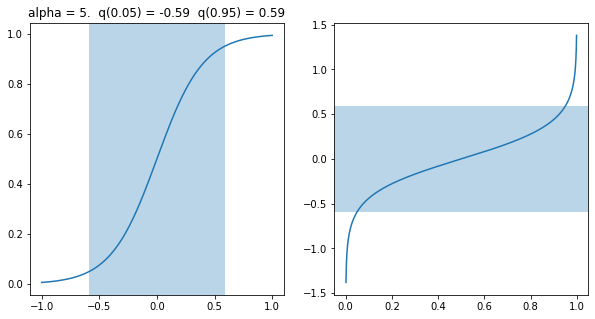

In [234]:
def sigma_inv(y, alpha):
    return -1 / alpha * np.log(1 / y - 1)

def sigma(y, alpha):
    return 1 / (1 + np.exp(- alpha * x))

N = 1000
ALPHA = 5
q1 = sigma_inv(0.05, ALPHA)
q2 = sigma_inv(0.95, ALPHA)

fig = plt.figure(figsize=(10, 5))

x = np.linspace(-1, 1, N)
y = sigma(x, ALPHA)
ax = fig.add_subplot(121)
ax.plot(x, y)
ax.set_title(f"alpha = {ALPHA}.  q(0.05) = {round(q1, 2)}  q(0.95) = {round(q2, 2)}")
ax.axvspan(q1, q2, alpha=.3,)

x = np.linspace(0.001, 0.999, N)
y = sigma_inv(x, ALPHA)
ax = fig.add_subplot(122)
ax.plot(x, y)
ax.axhspan(q1, q2, alpha=.3)


# Dataset

## Rectangles

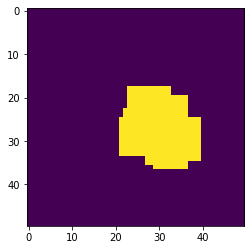

In [11]:
reload_modules()
x, rect_args = gfo.random_multi_rect(
    size=(50, 50), 
    n_rectangles=8,
    max_shape=(10, 10),
    return_rects=True, 
    first_rect_args={
        "top_left_x_props": (.3, .7),
        "top_left_y_props": (.3, .7)
    }
)
plt.imshow(x)


torch.Size([4, 1, 50, 50]) torch.Size([4, 50, 50])
CPU times: user 657 ms, sys: 8.74 ms, total: 666 ms
Wall time: 418 ms


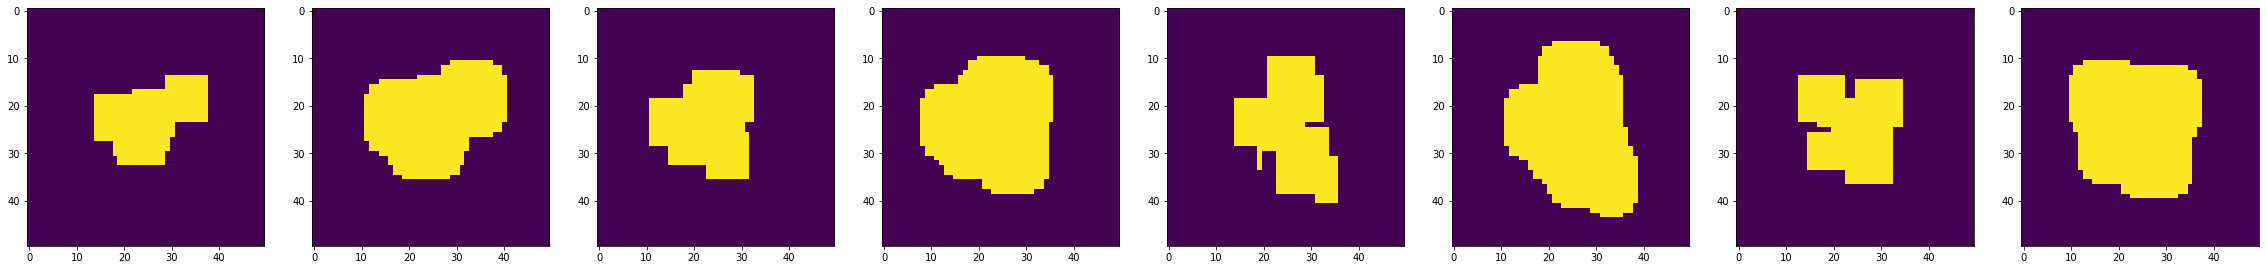

In [6]:
%%time
reload_modules()
dataset = mrda.MultiRectDataset(size=(50, 50), n_rectangles=8, max_shape=(10, 10), selem=morp.disk(3))
# input_, target = dataset[0]
dataloader = DataLoader(dataset, batch_size=4)

inputs, targets = next(iter(dataloader))
print(inputs.shape, targets.shape)

plot_horizontal(
    reduce(lambda a,b: a+b, 
           [[inpt[0].cpu(), target.cpu()] for (inpt, target) in zip(inputs, targets)]))

## Disks

In [29]:
ar = np.zeros((50, 50))
radius = 10
center = (14, 31)

XX, YY = np.meshgrid(np.arangee(ar.shape[0]), np.arange(ar.shape[1]))

In [31]:
idxes = np.sqrt((XX - center[0])**2 + (YY - center[1])**2) - radius

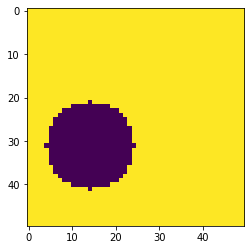

In [33]:
plt.imshow(idxes > 0)

In [89]:
min(center_x - min_x, max_x - center_x, max_shape[0] // 2)

5

In [346]:
reload_modules()
size = (50, 50)
n_shapes = 10
max_shape = (10, 10)
borders = (.1, .9)

all_diskorect = [np.zeros(size)]
min_x, min_y = int(size[0] * borders[0]), int(size[1] * borders[0])
max_x, max_y = int(size[0] * borders[1]), int(size[1] * borders[1])



In [194]:
min(center_x - min_x, max_x - center_x, max_shape[0] // 2)

2

In [207]:
max_shape[0]//2

5

center pre clip 24 48
center: 24 43
W1 W2 L1 L2 22 26 41 44
802.0


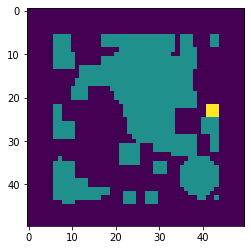

In [400]:

diskorect = all_diskorect[-1] + 0
not_0 = np.where(1 - diskorect)
rand_idx = random.choice(range(len(not_0[0])))
center_x, center_y = not_0[0][rand_idx], not_0[1][rand_idx]

print("center pre clip", center_x, center_y)
center_x = min(max_x - 2, max(min_x + 2, center_x))
center_y = min(max_y - 2, max(min_y + 2, center_y))

print("center:", center_x, center_y)

if np.random.rand() > .5:
    W1 = np.random.randint(1, min(center_x - min_x, max_shape[0] // 2))
    W2 = np.random.randint(1, min(max_x - center_x, max_shape[0] // 2))

    L1 = np.random.randint(1, min(center_y - min_y, max_shape[1] // 2))
    L2 = np.random.randint(1, min(max_y - center_y, max_shape[1] // 2))

    diskorect[center_x-W1:center_x+W2, center_y-L1:center_y+L2] = 1
    print("W1 W2 L1 L2", center_x-W1, center_x+W2, center_y-L1, center_y+L2)


else:
    radius = np.random.randint(1, min(center_x - min_x, max_x - center_x, max_shape[0]))
    radius = min(max_x - center_x, center_x - min_x, max_y - center_y, center_y - min_y, radius)
    gfo2.draw_disk(diskorect, (center_x, center_y), radius)
    print("r=", radius)

all_diskorect.append(diskorect)

disko_to_show = diskorect + 0
disko_to_show[(diskorect - all_diskorect[-2]).astype(bool)] = 2
plt.imshow(disko_to_show)
print(diskorect.sum())

In [336]:
all_diskorect[-2][39, 29]

1.0

In [414]:
reload_modules()
drc = gfo2.get_random_diskorect((50, 50), 30, (15, 15),)

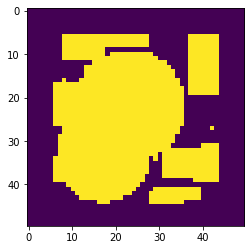

In [415]:
plt.imshow(drc)

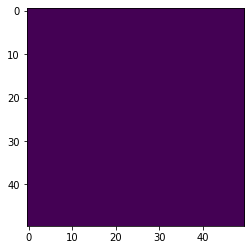

In [54]:
plt.imshow(drc)

# Net

In [19]:
reload_modules()
mpc_arctan = bise.BiSE(
    in_channels=1, out_channels=1, kernel_size=(5, 5), activation_threshold_mode='arctan')
mpc_sigmoid = bise.BiSE(
    in_channels=1, out_channels=1, kernel_size=(5, 5), activation_threshold_mode='sigmoid')


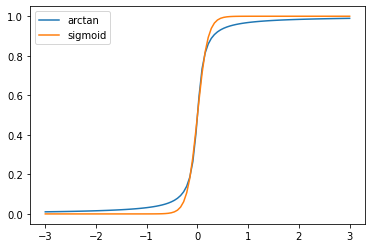

In [22]:
x = torch.tensor(np.linspace(-3, 3, 100))
plt.plot(x.detach(), mpc_arctan.activation_threshold_fn(x).detach(), label='arctan')
plt.plot(x.detach(), mpc_sigmoid.activation_threshold_fn(x).detach(), label='sigmoid')
plt.legend()

In [22]:
wghts = 100 * (torch.tensor([
    [1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 0, 1, 0],
    [0, 0, 0, 0, 1],
]) - .5)
se = torch.sigmoid(wghts) > .5

mpc.activation_P = nn.Parameter(torch.FloatTensor([3]))
# mpc.conv.bias = nn.Parameter(torch.FloatTensor([-1]))  # dilation
mpc.conv.bias = nn.Parameter(torch.FloatTensor([-se.sum()]))  # erosion
mpc.conv.weight = nn.Parameter(wghts.float().unsqueeze(0).unsqueeze(0))

In [23]:
inpt = torch.tensor(x[np.newaxis, ...]).float().unsqueeze(0)
output = mpc.conv._conv_forward(inpt, mpc._normalized_weight, mpc.bias).detach()
print(np.unique(output, return_counts=True))
output = torch.sigmoid(output * mpc.activation_P).detach()
np.unique(output, return_counts=True)


(array([-5., -4., -3., -2., -1.,  0.], dtype=float32), array([2085,   68,   59,   53,   50,  185]))


(array([3.0590220e-07, 3.0590223e-07, 6.1441742e-06, 1.2339458e-04,
        2.4726230e-03, 4.7425874e-02, 5.0000000e-01], dtype=float32),
 array([2081,    4,   68,   59,   53,   50,  185]))

In [13]:
%%time
reload_modules()
otp = mpc(torch.tensor(x[np.newaxis, ...]).float().unsqueeze(0))
# target = arm.array_dilation(x, se)
target = arm.array_erosion(x, se)

CPU times: user 34 ms, sys: 0 ns, total: 34 ms
Wall time: 7.1 ms


/hdd/aouadt/these/projets/3d_segm/general/array_morphology.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(ar).unsqueeze(0).unsqueeze(0).float().to(device)


In [192]:
np.unique(otp.detach(), return_counts=True)

(array([3.0590220e-07, 3.0590223e-07, 6.1441742e-06, 1.2339458e-04,
        2.4726230e-03, 4.7425874e-02, 5.0000000e-01], dtype=float32),
 array([2008,    4,   80,   72,   66,   62,  208]))

In [187]:
mpc._normalized_weight

tensor([[[[0.9890, 0.0110, 0.0110, 0.0110, 0.0110],
          [0.0110, 0.9890, 0.0110, 0.0110, 0.0110],
          [0.0110, 0.0110, 0.9890, 0.0110, 0.0110],
          [0.0110, 0.0110, 0.0110, 0.9890, 0.0110],
          [0.0110, 0.0110, 0.0110, 0.0110, 0.9890]]]],
       grad_fn=<SigmoidBackward>)

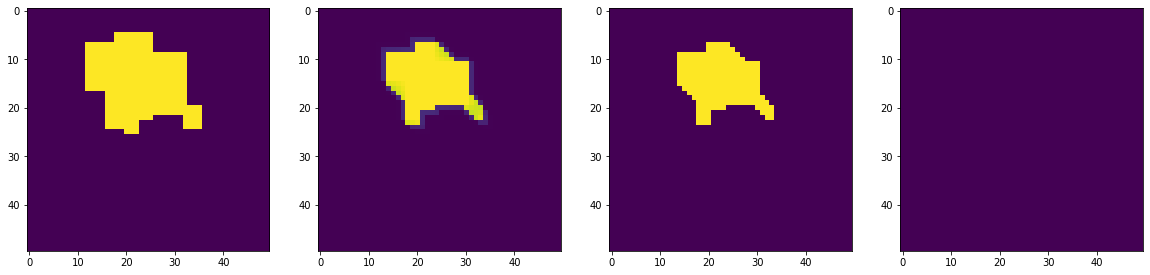

In [188]:
plot_horizontal([
    x,
    otp.detach()[0, 0],
    target,
    ((otp.detach()[0, 0] > .4) - target).abs()
]);


# Training

## Dilation / Erosion

Opening 49


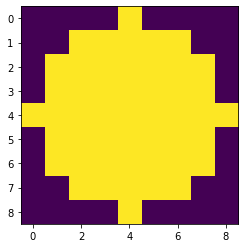

In [118]:
reload_modules()

# morp_operation = 'Dilation'
# morp_operation = 'Erosion'
morp_operation = 'Opening'

# selem = np.zeros((5, 5))
# selem[np.arange(5), 5 - np.arange(1, 6)] = 1
# selem[np.arange(5), np.arange(5)] = 1
# selem[:, 2] = 1
# selem[2, :] = 1
selem = morp.disk(4)
plt.imshow(selem)
print(morp_operation, selem.sum())

dataloader = mrda.get_loader(
    batch_size=32, 
    n_inputs=500_000,
#     random_gen_fn=gfo.random_multi_rect,
#     random_gen_args={
#         'size': (50, 50), 
#         'n_rectangles': 8,
#         'max_shape': (10, 10), 
#     },
    random_gen_fn=gfo3.get_random_rotated_diskorect,
    random_gen_args={'size': (50, 50), 'n_shapes': 15, 'max_shape': (15, 15), 'p_invert': .5},
    device=device, 
    selem=selem,
    morp_operation=morp_operation,
)

0


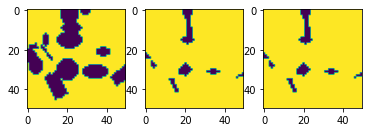

In [139]:
img, target = next(iter(dataloader))
img = img[0, 0].detach().cpu()

fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(img)

selems = []

selem = np.zeros((5, 5))
selem[2, :] = 1
selems.append(selem)

selem = np.zeros((5, 5))
selem[:, 2] = 1
selems.append(selem)


morp_fn = arm.sequentiel_morp_operations(
    img,
    selems=selems,
    operations=['dilation', 'dilation']
)

oimg = morp_fn(img)
ax = fig.add_subplot(132)
ax.imshow(oimg)

oimg2 = arm.array_dilation(img, selem=np.ones((5, 5)))
ax = fig.add_subplot(133)
ax.imshow(oimg2)

print((oimg - oimg2).sum())

In [130]:
img.shape

torch.Size([50, 50])

In [11]:
reload_modules()
loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam

if morp_operation.lower() != "opening":
    observables = [
        obs.PlotParametersDilation(100),
        obs.PlotPreds(100),
        obs.WeightsHistogramDilation(1000)
    ]
    
    model = lbise.LightningBiSE(
        model_args={
            "in_channels": 1, "out_channels": 1, "kernel_size": (5, 5)
        },
        learning_rate=1e-2,
        loss=loss,
        optimizer=optimizer,
        output_dir="deep_morpho/results",
        observables=observables
    )
else:
    observables = [
        obs.PlotParametersMultipleDilations(1),
        obs.PlotPreds(1),
        obs.WeightsHistogramMultipleDilations(1)
    ]
    
    model = lon.LightningOpeningNet(
        model_args={
            "share_weights": True, "in_channels": 1, "out_channels": 1, "kernel_size": (5, 5)
        },
        learning_rate=5e-2,
        loss=loss,
        optimizer=optimizer,
        output_dir="deep_morpho/results",
        observables=observables
    )


model.to(device)

logger = TensorBoardLogger("deep_morpho/results", name=morp_operation)
print(logger.log_dir)

logger.experiment.add_graph(model, torch.ones(1, 1, 50, 50).to(device))
logger.experiment.add_image("target_SE", selem[np.newaxis, :].astype(float))

trainer = Trainer(
    max_epochs=1,
    gpus=1 if torch.cuda.is_available() else 0,
    logger=logger,
    progress_bar_refresh_rate=10,
    callbacks=observables.copy()
)

trainer.fit(model, dataloader)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | OpeningNet        | 55    
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
55        Trainable params
0         Non-trainable params
55        Total params
0.000     Total estimated model params size (MB)


deep_morpho/results/Opening/version_13


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [68]:
img, target = dataloader.dataset[0]
otp = model(img.unsqueeze(0).cpu())


- Unet Version 15: training on $3 \cdot 10^8$ images with softmax before weight
- Dilation Version 0: training on $3 \cdot 10^8$ images without softmax, max min norm

In [103]:
model = model.load_from_checkpoint(join("deep_morpho/results/Unet/version_15/checkpoints/epoch=0-step=93749.ckpt"))

<ipython-input-3-2732c24916c7>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(5*n_figs, 5))


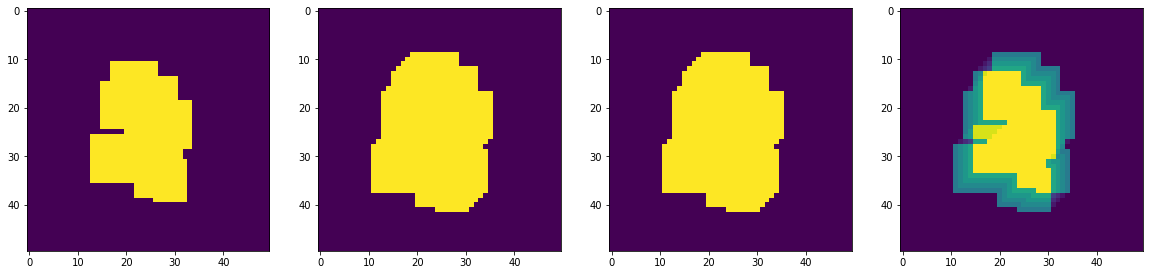

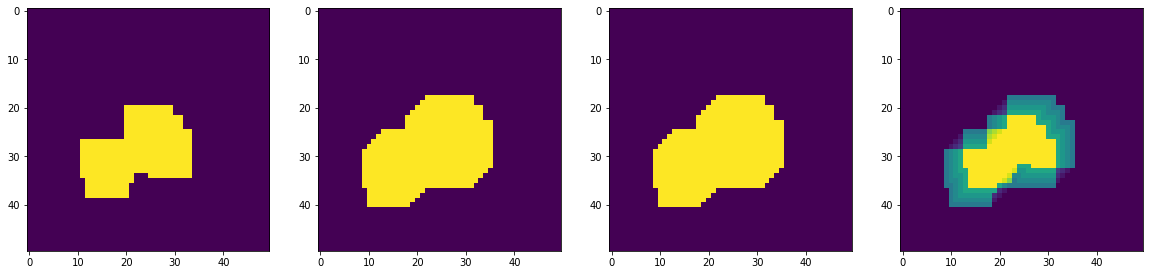

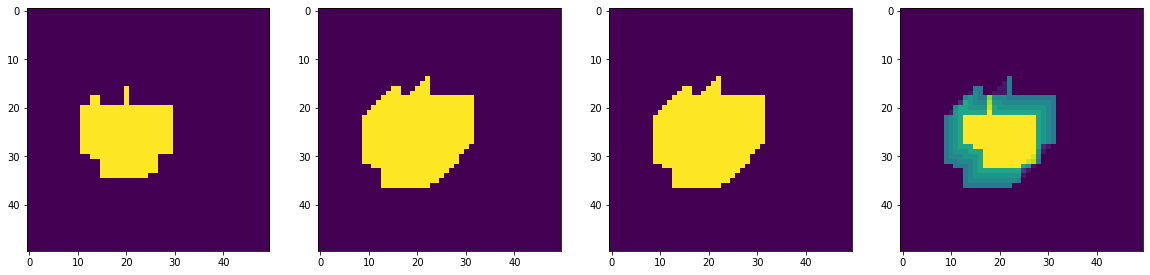

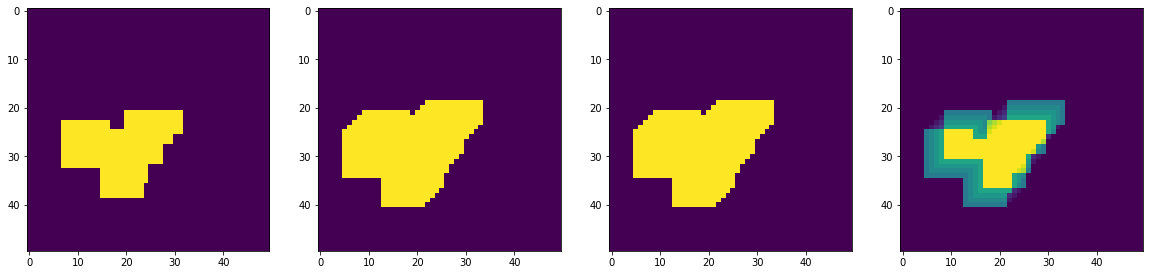

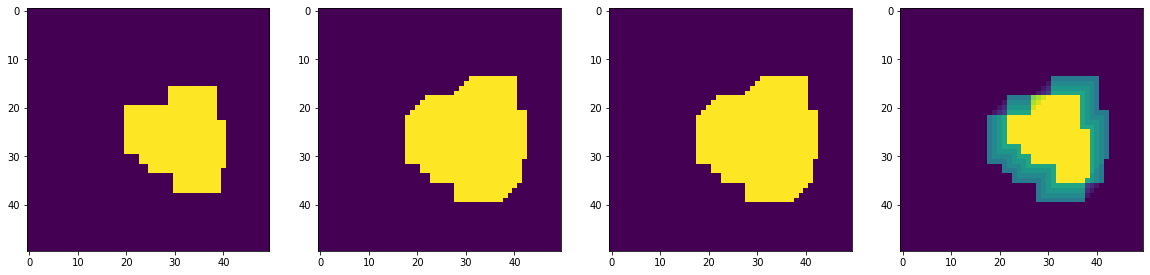

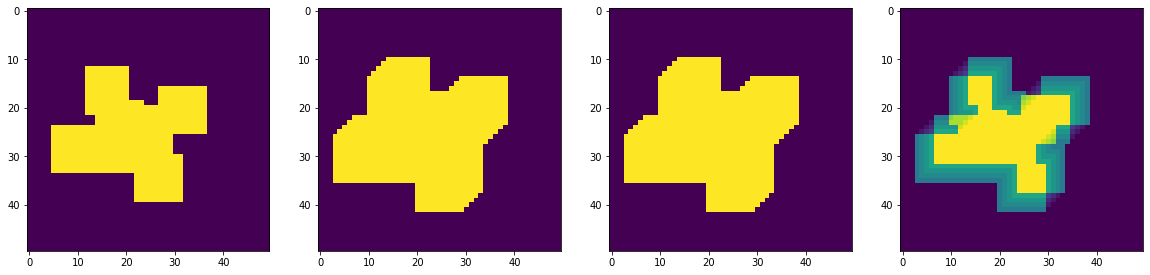

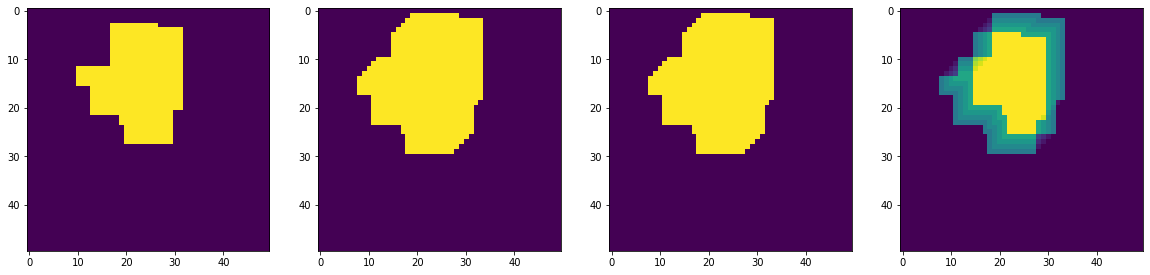

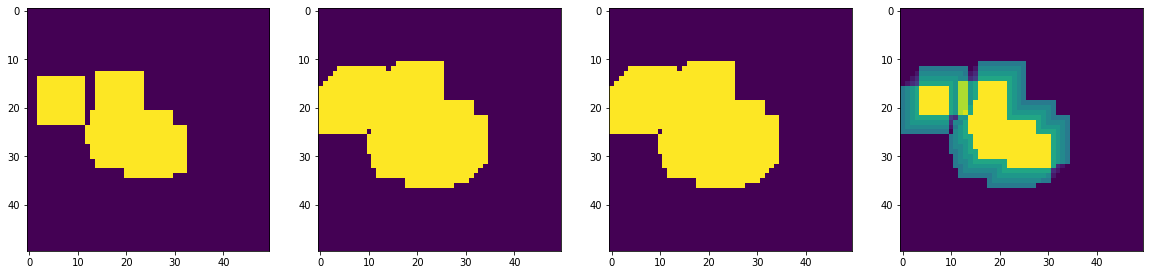

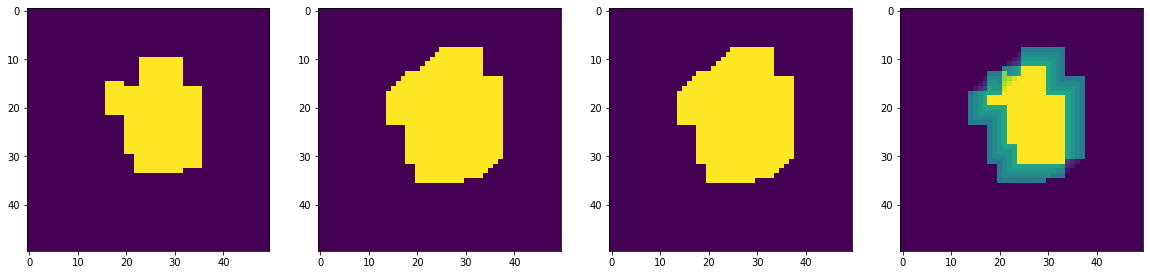

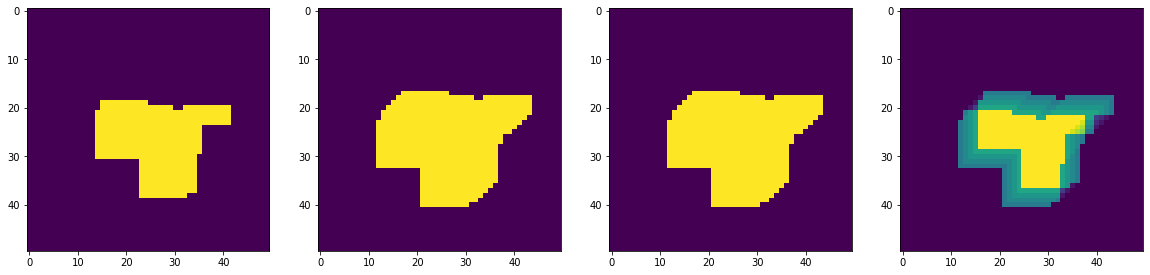

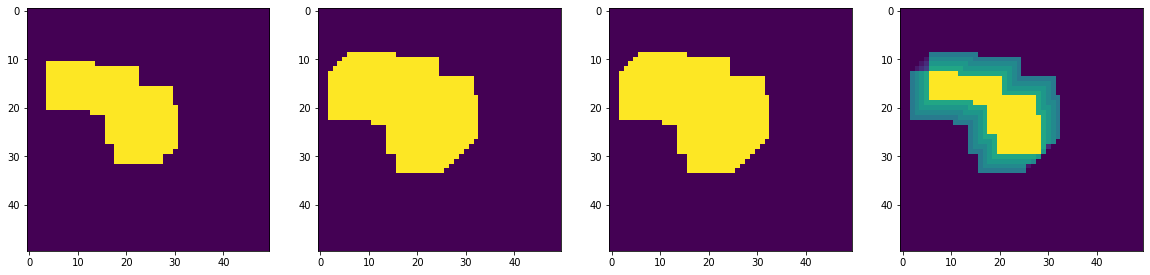

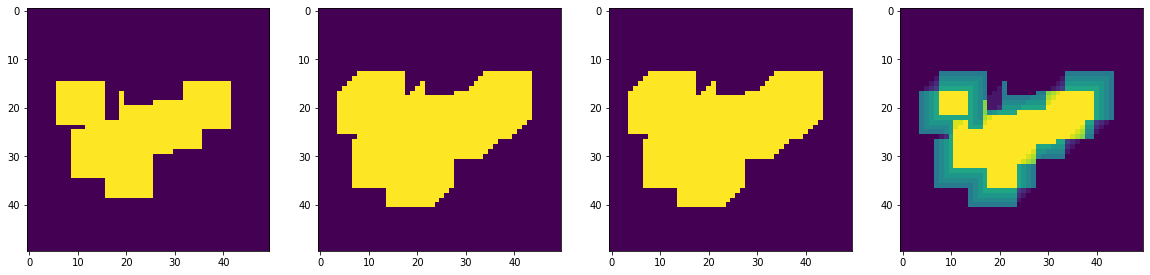

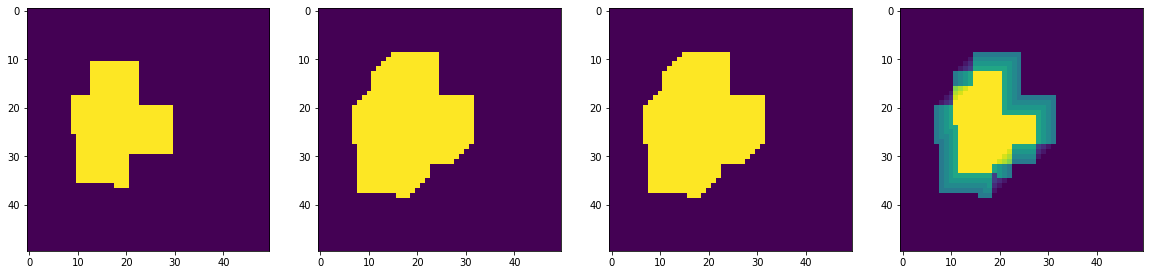

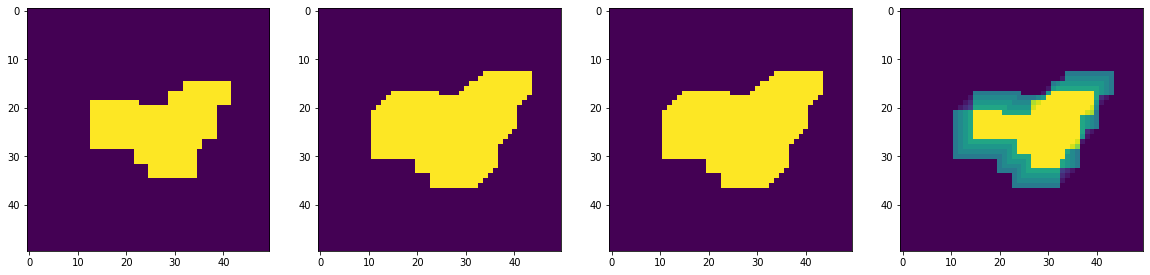

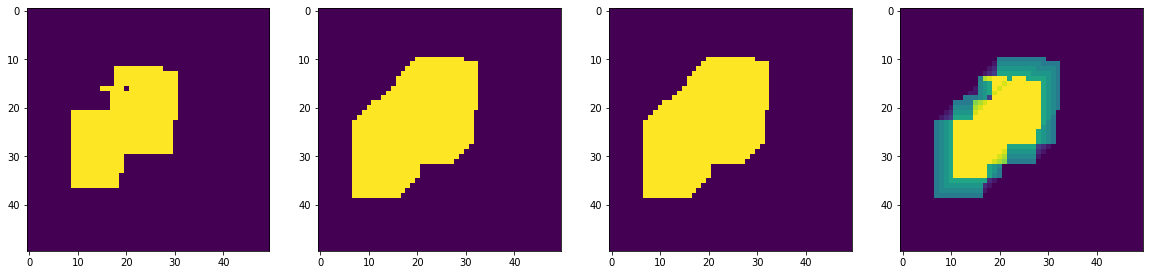

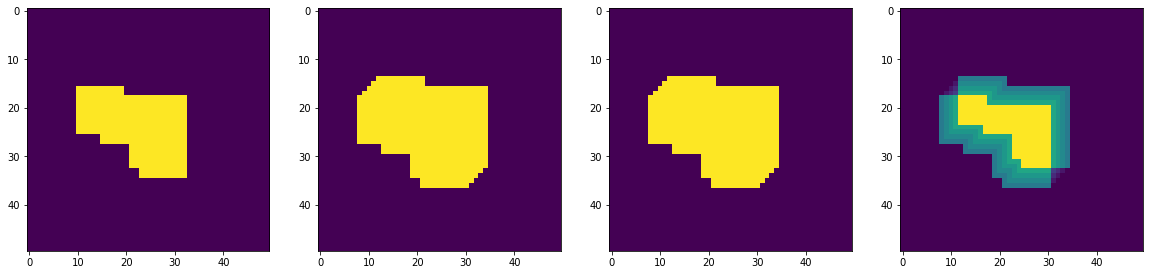

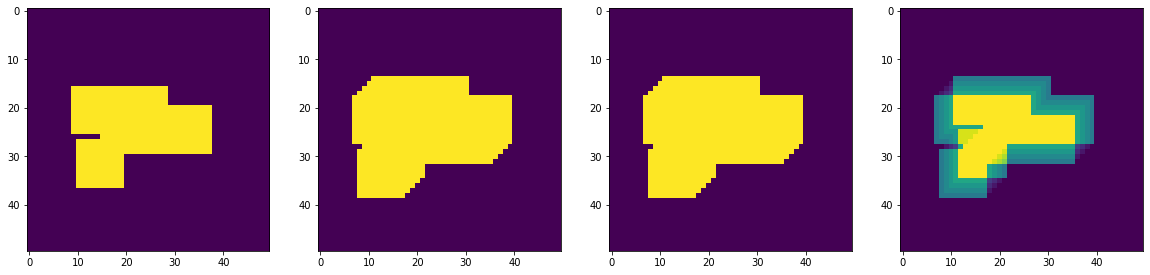

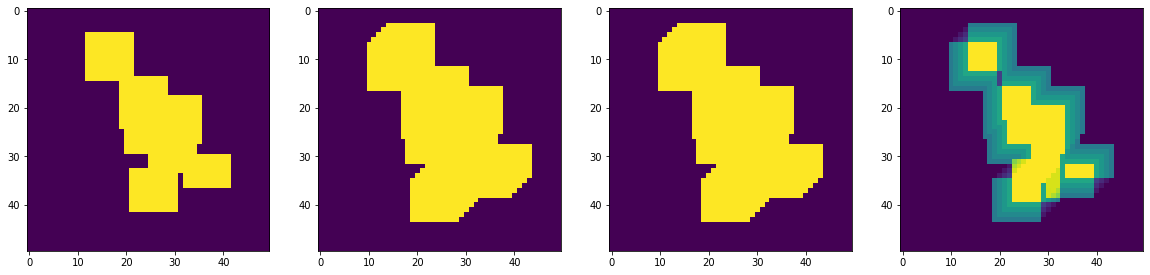

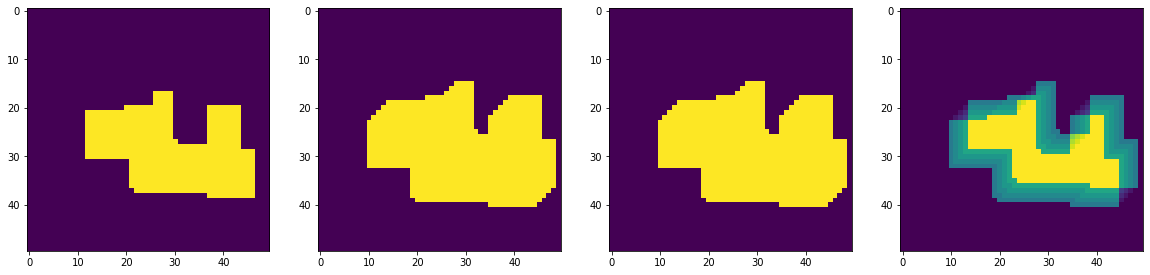

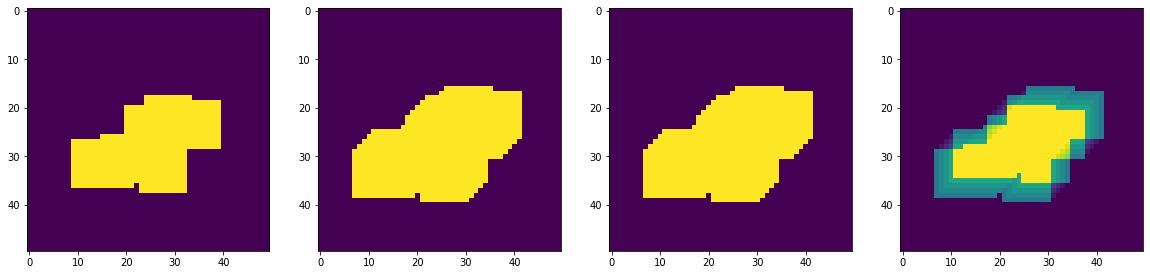

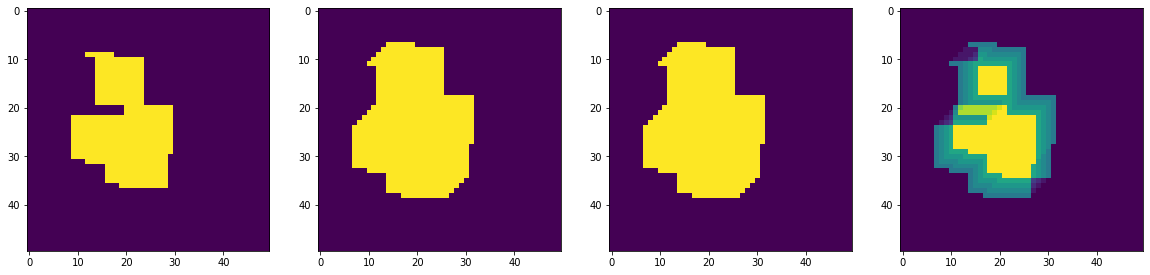

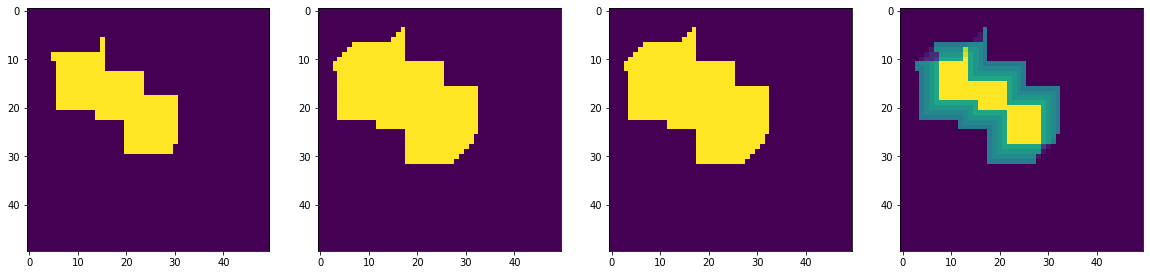

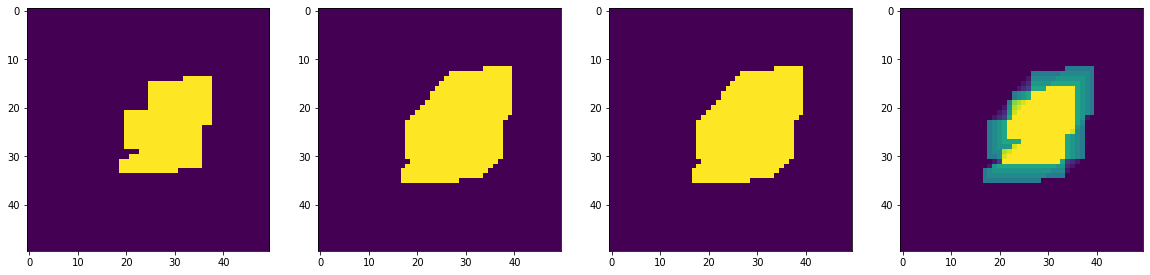

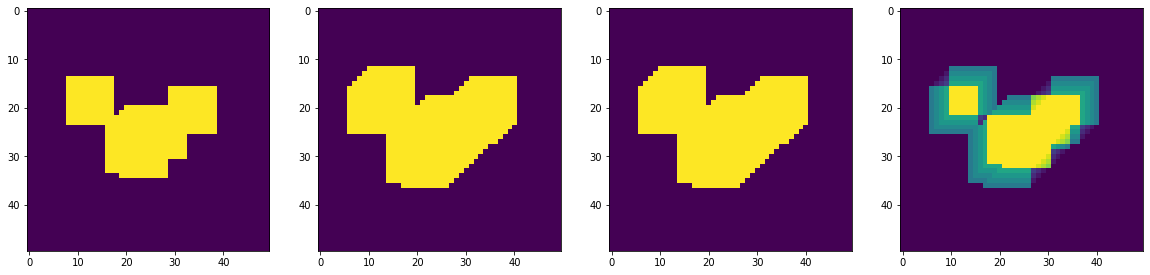

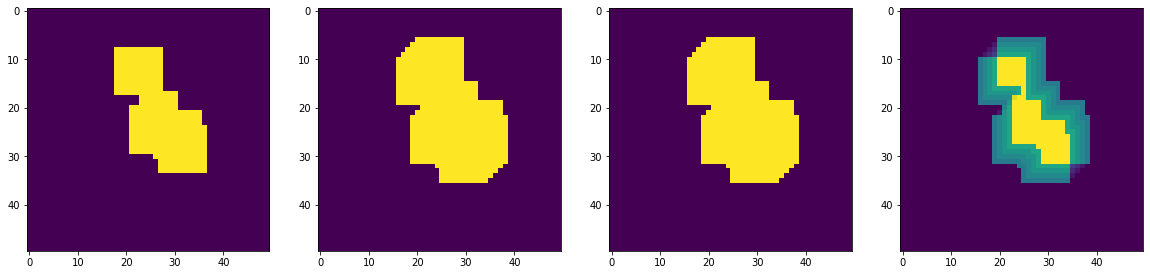

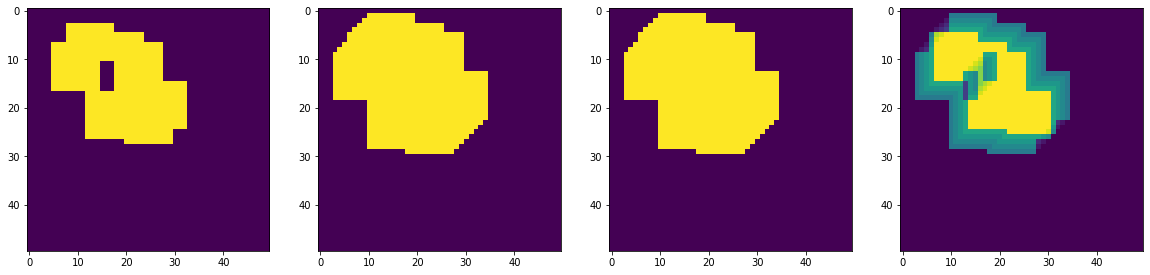

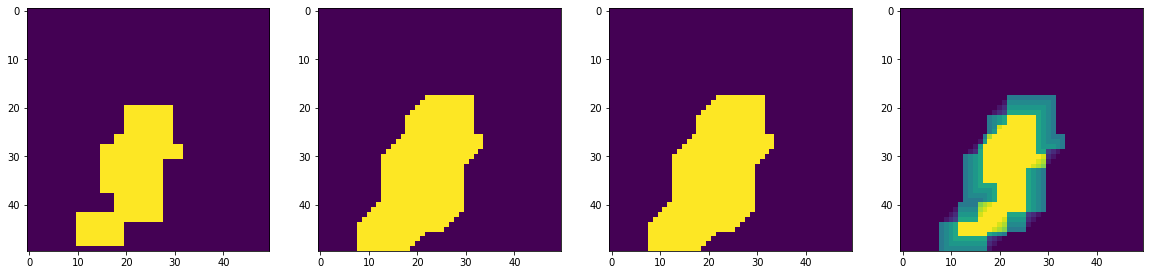

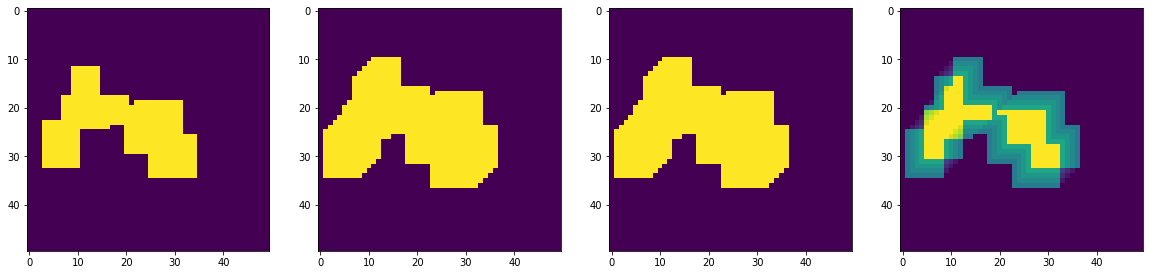

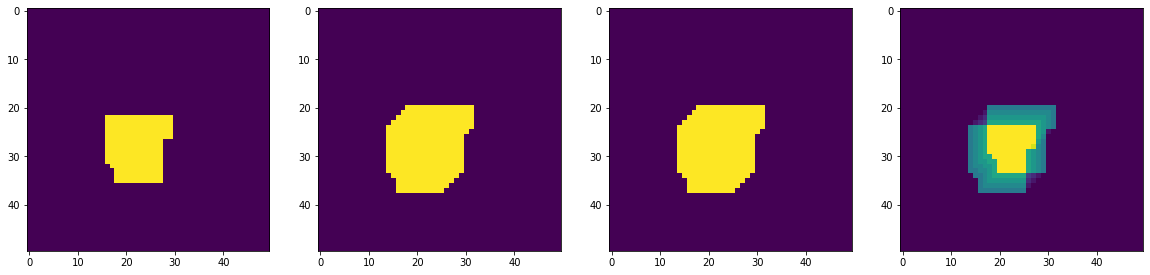

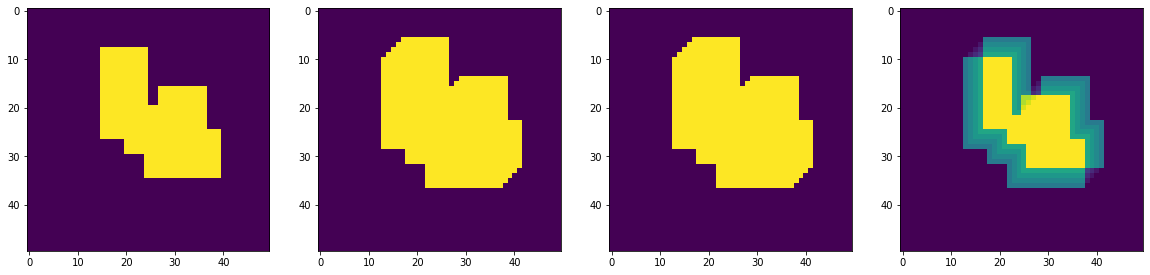

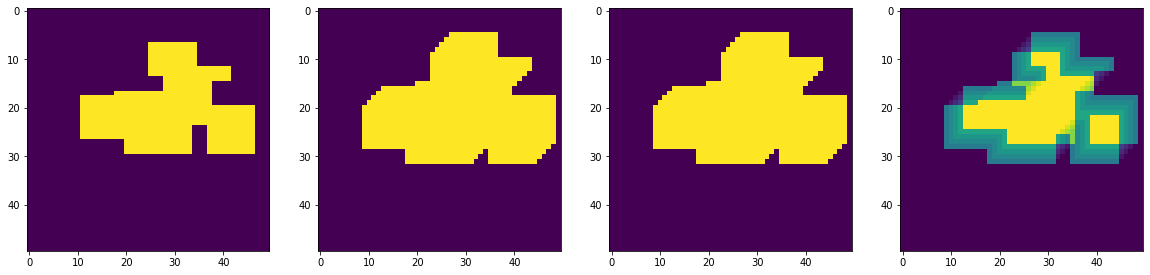

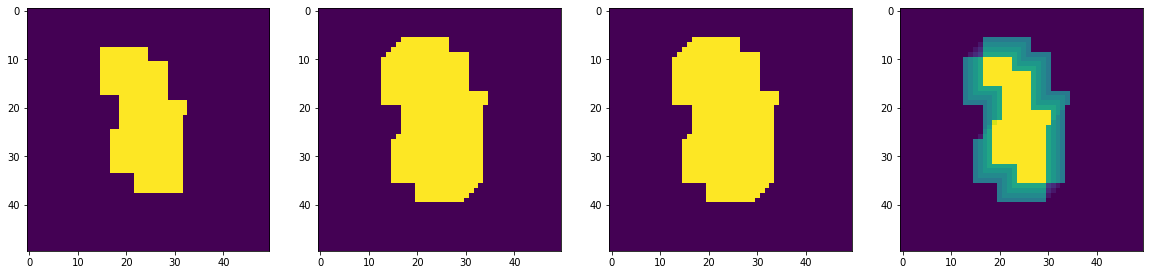

In [113]:
model.to(device)
inputs, targets = next(iter(dataloader))
outputs = model(inputs)
for idx in range(len(inputs)):
    plot_horizontal([tensor[idx].squeeze().cpu().detach() for tensor in [
        inputs, targets, outputs > 0.05, outputs]])

In [110]:
print(model.model.conv.weight)
print(model.model._normalized_weight)
print(model.model.P_)

Parameter containing:
tensor([[[[-0.1435, -0.1434, -0.1436, -0.1433,  0.9307],
          [-0.1434, -0.1434, -0.1434,  0.0202, -0.1433],
          [-0.1435, -0.1433,  0.0130, -0.1434, -0.1434],
          [-0.1433,  0.0191, -0.1431, -0.1431, -0.1435],
          [ 0.9319, -0.1432, -0.1434, -0.1435, -0.1435]]]], device='cuda:0',
       requires_grad=True)
tensor([[[[1.4809e-05, 5.0633e-05, 0.0000e+00, 8.8175e-05, 4.0749e-01],
          [7.8492e-05, 6.5323e-05, 7.1099e-05, 6.2133e-02, 9.0181e-05],
          [3.1579e-05, 8.9384e-05, 5.9403e-02, 5.0689e-05, 6.7584e-05],
          [8.9418e-05, 6.1683e-02, 1.8620e-04, 1.8275e-04, 8.5349e-06],
          [4.0793e-01, 1.2621e-04, 4.5783e-05, 1.2316e-05, 1.6386e-05]]]],
       device='cuda:0', grad_fn=<DivBackward0>)
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)


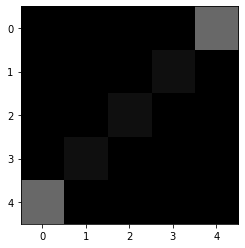

In [109]:
# plt.imshow(torch.sigmoid(model.model.conv.weight).cpu().detach()[0, 0], cmap='gray',
#           vmin=0, vmax=1)
plt.imshow(model.model._normalized_weight.cpu().detach()[0, 0], cmap='gray',
          vmin=0, vmax=1)

## Opening

9.0


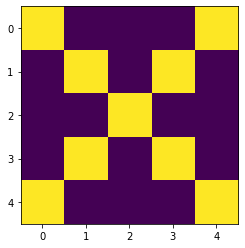

In [16]:
reload_modules()
selem = np.zeros((5, 5))
selem[np.arange(5), 5 - np.arange(1, 6)] = 1
selem[np.arange(5), np.arange(5)] = 1
# selem = morp.disk(2)
plt.imshow(selem)
print(selem.sum())

dataloader = mrda.get_loader(
    batch_size=32, 
    n_inputs=1_000_000, 
    size=(50, 50), 
    n_rectangles=8,
    device=device, 
    max_shape=(10, 10), 
    selem=selem,
    morp_operation="opening",
)

In [17]:
reload_modules()
loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam

observables = [
    obs.PlotParametersMultipleDilations(1000),
    obs.PlotPreds(),
    obs.WeightsHistogramMultipleDilations(1000)
]

model = lon.LightningOpeningNet(
    model_args={
        "share_weights": True, "in_channels": 1, "out_channels": 1, "kernel_size": (5, 5)
    },
    learning_rate=1e-2,
    loss=loss,
    optimizer=optimizer,
    output_dir="deep_morpho/results",
    observables=observables
)
model.to(device)

logger = TensorBoardLogger("deep_morpho/results", name='Opening')
print(logger.log_dir)

logger.experiment.add_graph(model, torch.ones(1, 1, 50, 50).to(device))
logger.experiment.add_image("target_SE", selem[np.newaxis, :])

trainer = Trainer(
    max_epochs=1,
    gpus=1 if torch.cuda.is_available() else 0,
    logger=logger,
    progress_bar_refresh_rate=10,
    callbacks=observables.copy()
)

trainer.fit(model, dataloader)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | OpeningNet        | 56    
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
56        Trainable params
0         Non-trainable params
56        Total params
0.000     Total estimated model params size (MB)


deep_morpho/results/Opening/version_0


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/hdd/aouadt/these/projets/3d_segm/general/array_morphology.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(ar).unsqueeze(0).unsqueeze(0).float().to(device)


# BiMoNN

Dilation 29


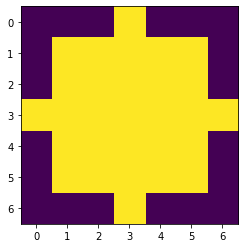

In [4]:
reload_modules()

morp_operation = 'Dilation'
# morp_operation = 'Erosion'
# morp_operation = 'Opening'

# selem = np.zeros((5, 5))
# selem[np.arange(5), 5 - np.arange(1, 6)] = 1
# selem[np.arange(5), np.arange(5)] = 1
# selem[:, 2] = 1
# selem[2, :] = 1
selem = morp.disk(3)
plt.imshow(selem)
print(morp_operation, selem.sum())

dataloader = mrda.get_loader(
    batch_size=32, 
    n_inputs=500_000,
#     random_gen_fn=gfo.random_multi_rect,
#     random_gen_args={
#         'size': (50, 50), 
#         'n_rectangles': 8,
#         'max_shape': (10, 10), 
#     },
    random_gen_fn=gfo3.get_random_rotated_diskorect,
    random_gen_args={'size': (50, 50), 'n_shapes': 15, 'max_shape': (15, 15), 'p_invert': .5,
                    'border': (4, 4)},
    device=device, 
    selem=selem,
    morp_operation=morp_operation,
)

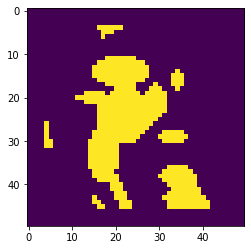

In [5]:
img, target = next(iter(dataloader))
plt.imshow(img[0, 0].cpu().detach())

In [6]:
reload_modules()

net = bimonn.BiMoNN(
    kernel_size=[5, 5, 5, 7],
    logical_not=False,
    weight_P=1,
    weight_threshold_mode="sigmoid",
    activation_P=100,
    activation_threshold_mode="sigmoid",
    init_bias_value=-0.5,
    out_channels=1
)
net.to(device)

net_dil = models.BiSE(kernel_size=(7, 7), activation_P=100, init_bias_value=-.5)
net_dil.to(device)

TypeError: __init__() got an unexpected keyword argument 'weight_threshold_mode'

In [26]:
otp2.shape

torch.Size([32, 1, 52, 52])

In [27]:
otp1 = net(img)
otp2 = net_dil(img)

print(otp1.shape, otp2.shape)

(otp1 - otp2).abs().sum()

torch.Size([32, 1, 50, 50]) torch.Size([32, 1, 50, 50])


tensor(0., device='cuda:0', grad_fn=<SumBackward0>)

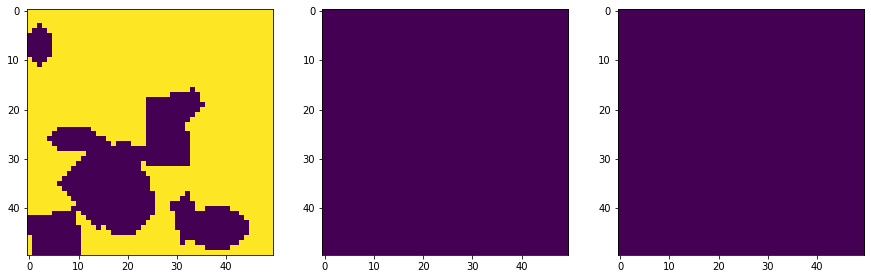

In [28]:
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(131)
ax.imshow(img[0, 0].cpu().detach())

ax = fig.add_subplot(132)
ax.imshow(otp1[0, 0].cpu().detach())

ax = fig.add_subplot(133)
ax.imshow(otp2[0, 0].cpu().detach())

In [43]:
net.bises[0].weights

Parameter containing:
tensor([[[[0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.]]]], device='cuda:0', requires_grad=True)

In [44]:
net_dil.weights

Parameter containing:
tensor([[[[0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.]]]], device='cuda:0', requires_grad=True)

In [40]:
net_dil.conv.weight.shape

torch.Size([1, 1, 7, 7])

# LogicalNotBise

<IPython.core.display.Javascript object>


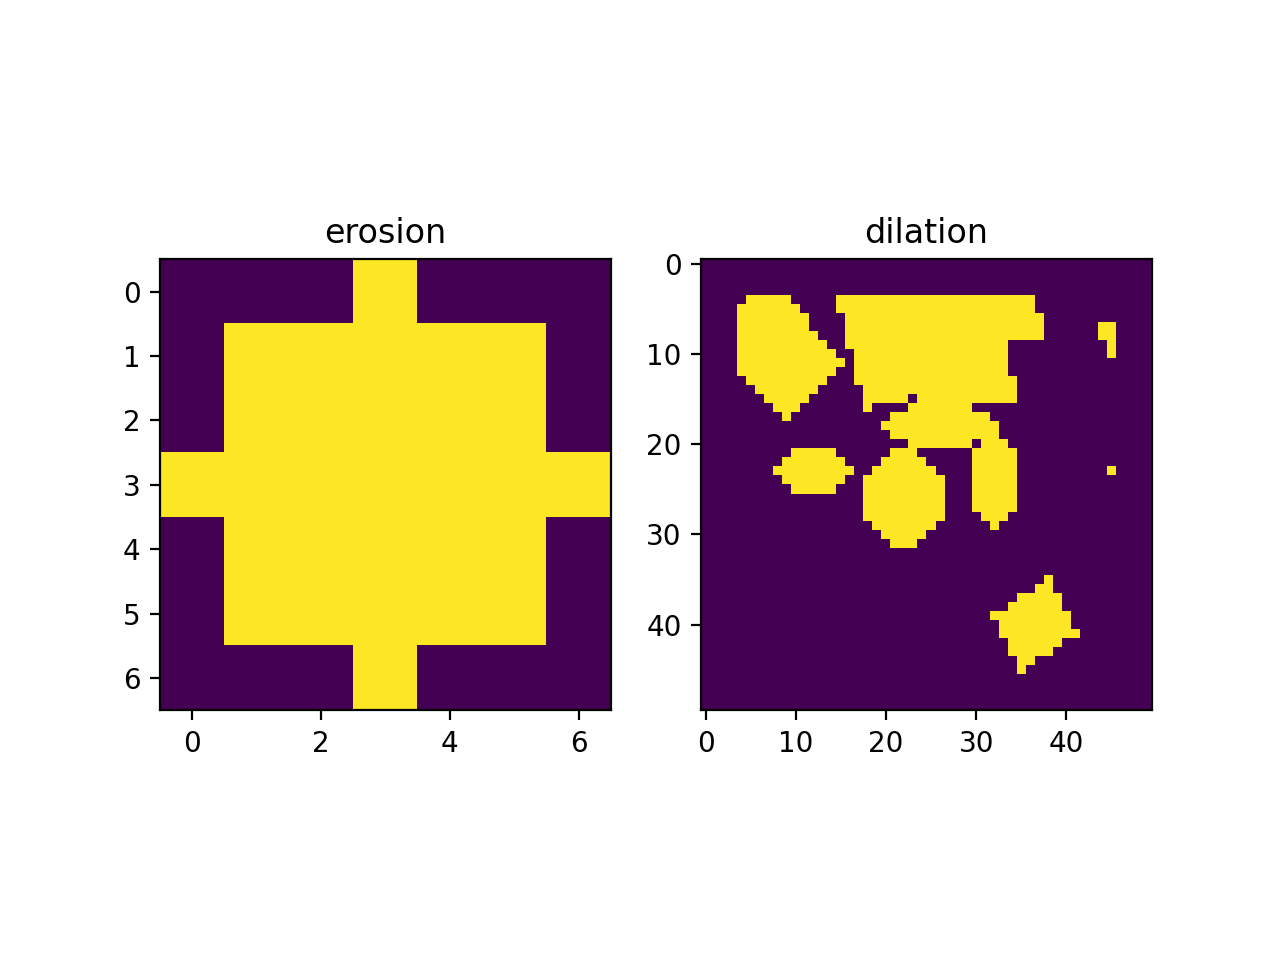

In [5]:
reload_modules()

morp_operation = arm.SequentialMorpOperations(
    operations=['erosion', 'dilation'],
    selems=[selm.disk(3), selm.disk(3)],
    device=device,
    name="opening"
)

fig = plt.figure()
for selem_idx, selem in enumerate(morp_operation.selems):
    ax = fig.add_subplot(1, len(morp_operation), selem_idx + 1)
    ax.imshow(selem)
    ax.set_title(morp_operation.operations[selem_idx])

dataloader = mrda.get_loader(
    batch_size=32, 
    n_inputs=500_000,
    random_gen_fn=gfo3.get_random_rotated_diskorect,
    random_gen_args={'size': (50, 50), 'n_shapes': 15, 'max_shape': (15, 15), 'p_invert': .5},
    device=device, 
    selem=selem,
    morp_operation=morp_operation.morp_fn,
)

In [14]:
img, target = next(iter(dataloader))
img.requires_grad = False
target.requires_grad = False

/hdd/aouadt/these/projets/3d_segm/general/array_morphology.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(ar).unsqueeze(0).unsqueeze(0).float().to(device)


In [70]:
%%time

reload_modules()
alphas = np.linspace(-5, 5, 100)
loss_values2 = []
loss = nn.BCEWithLogitsLoss()
# for idx1, alpha1 in tqdm(enumerate(alphas)):

loss_values = np.zeros((len(alphas), len(alphas)))
with torch.no_grad():
    for idx1, alpha1 in tqdm(enumerate(alphas)):
    # for alpha1 in [-10]:
        for idx2, alpha2 in enumerate(alphas):
    #     for alpha2 in [-10]:
            net_dil = bimonn.BiMoNN(
                kernel_size=[(7, 7), (7, 7)], 
                logical_not=True, 
                activation_P=[20, 20], 
                alpha_init=[alpha1, alpha2],
#                 threshold_mode={"activation": "tanh", "weight": "tanh", "logical_not": "clamp"}
                threshold_mode="tanh"
            )
            for layer in net_dil.bises:
                layer.conv.weight.data = torch.FloatTensor(
                    morp_operation.selems[0].astype(float) * 10 - 5
                ).unsqueeze(0).unsqueeze(0)
            net_dil.to(device)

            with torch.no_grad():
    #             loss_values2.append(loss(net_dil(img).squeeze(), target).detach().item())
                loss_values[idx1, idx2] = loss(net_dil(img).squeeze(), target).detach().item()

100it [00:21,  4.66it/s]

CPU times: user 21 s, sys: 105 ms, total: 21.1 s
Wall time: 21.5 s


<IPython.core.display.Javascript object>


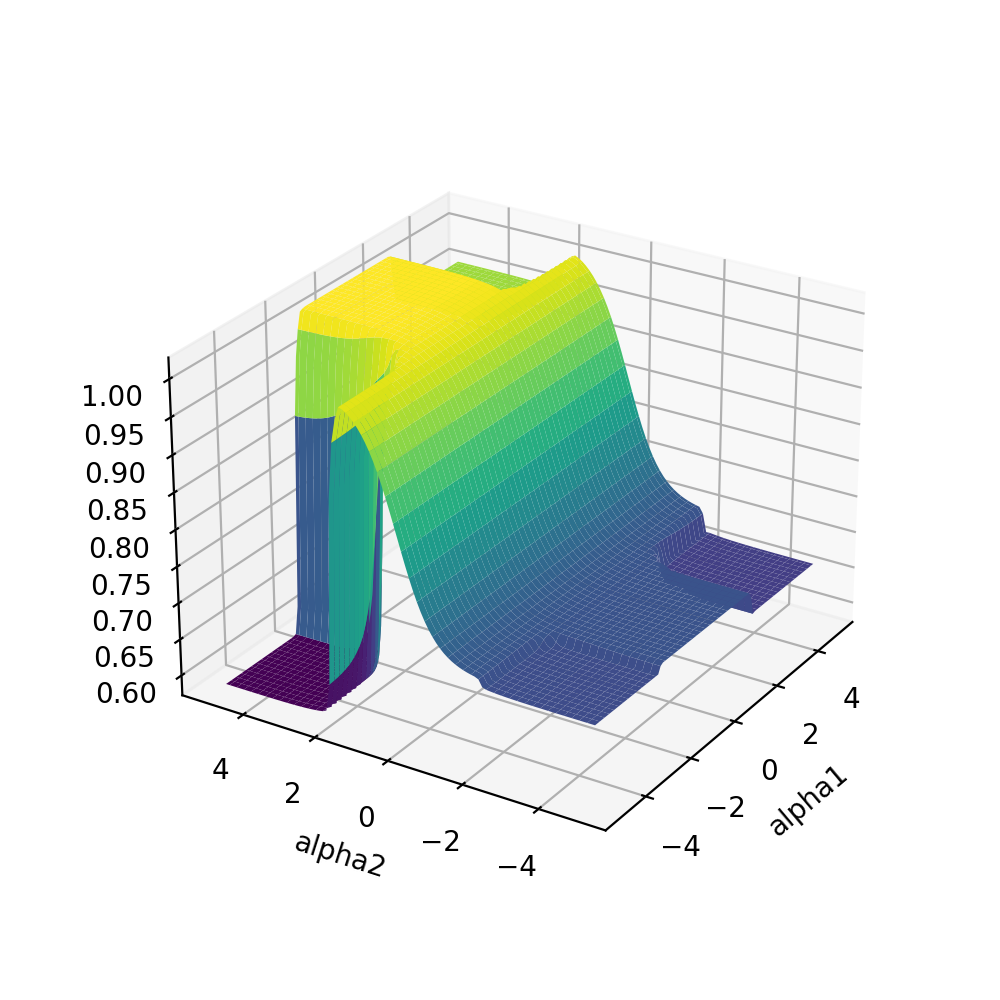

Text(0.5, 0, 'alpha2')

In [71]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(5, 5))

ax = plt.axes(projection='3d')

XX, YY = np.meshgrid(
#     net_dil.bises[0].logical_not_layer.threshold_layer(torch.tensor(alphas)), 
#     net_dil.bises[0].logical_not_layer.threshold_layer(torch.tensor(alphas)), 
    alphas,
    alphas
)
ax.plot_surface(YY, XX, loss_values, 
                cmap='viridis', edgecolor='none')
ax.set_xlabel("alpha1")
ax.set_ylabel("alpha2")

In [58]:
reload_modules()
net = bimonn.BiMoNN(
    kernel_size=[7, 7],
    logical_not=True,
    activation_P=20,
    alpha_init=[0, 1],
    threshold_mode={"activation": "tanh", "weight": "tanh", "logical_not": "clamp"},
)

# for layer in net_dil.bises:
#     layer.conv.weight.data = torch.FloatTensor(
#         morp_operation.selems[0].astype(float) * 10 - 5
#     ).unsqueeze(0).unsqueeze(0)
net.to(device)

BiMoNN(
  (layer1): LogicalNotBiSE(
    (conv): Conv2d(1, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (weight_threshold_layer): TanhLayer()
    (activation_threshold_layer): TanhLayer()
    (logical_not_layer): LogicalNotLayer(
      (threshold_layer): ClampLayer()
    )
  )
  (layer2): LogicalNotBiSE(
    (conv): Conv2d(1, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (weight_threshold_layer): TanhLayer()
    (activation_threshold_layer): TanhLayer()
    (logical_not_layer): LogicalNotLayer(
      (threshold_layer): ClampLayer()
    )
  )
)

In [49]:
def alpha_to(model, bise_idx, alpha_value):
    model.bises[bise_idx].logical_not_layer.alpha.requires_grad = False
    model.bises[bise_idx].logical_not_layer.alpha.fill_(alpha_value)


<IPython.core.display.Javascript object>


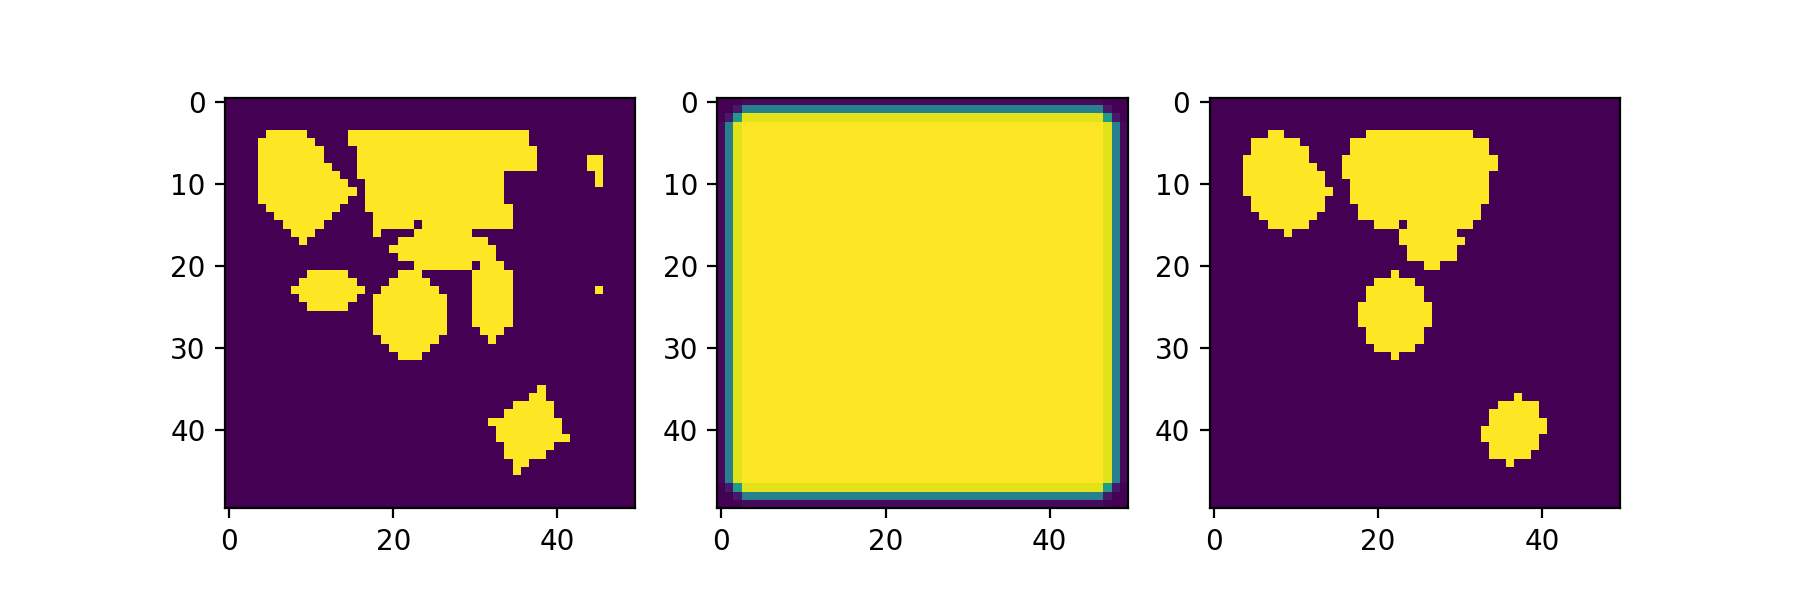

In [60]:
alpha_to(net, 0, .1)
alpha_to(net, 1, 1)
output = net(img).detach()

fig, ax = plt.subplots(1, 3, figsize=(9, 3))

ax[0].imshow(img[0, 0].cpu())
ax[1].imshow(output[0, 0].cpu())
ax[2].imshow(target[0].cpu())


In [24]:
output.shape

torch.Size([32, 1, 50, 50])